In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class BernoulliBanditEnv(object): 
    # Class that defines the environment with reward 0 and 1 with probability p.

    def __init__(self, num_arms=10, p=None):
        self.num_arms = num_arms
        self.actions = np.arange(num_arms)     # define set of actions

        if len(p)==1:
            self.p = np.random.beta(0.5, 0.5, size=num_arms)
        elif len(p) == num_arms:
            self.p = p
        else:
            raise Exception('Number of probabilities ({}) does not correspond to number of arms ({}).'.format(len(q), num_arms))
        self.best_action = np.argmax(self.p)   # Best action given env

    def reward(self, action):
        return np.random.binomial(1, p=self.p[action])


In [3]:
class Agent(object):
    # Class which defines the agent. Each agent has a decision rule and a learning rule.
    
    def __init__(self, learning_rule, decision_rule, param=None):
        self.decision_rule = decision_rule
        self.learning_rule = learning_rule

        if decision_rule == "epsilon-greedy":
            self.epsilon = param["epsilon"]
        
        if decision_rule == "UCB":
            self.UCB_param = param["UCB_param"]

        if decision_rule == "optimistic-greedy":
            self.optimistic_initial_value = param["optimistic_initial_value"]
    
    def environment(self, env, init_q):
        # initialize environment
        self.env = env                                  
        self.k = env.num_arms                           
        self.actions = np.arange(self.k)                
        self.act_count = np.zeros(self.k)               
        self.iteration = 0     
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha = np.random.uniform(size=self.k)
            self.beta = np.random.uniform(size=self.k)
        if len(init_q) == self.k:
            self.q_estimate = init_q
        else:
            raise Exception('Number of initial values ({}) does not correspond to number of arms ({}).'.format(len(init_q), self.k))

    def learn(self, a, r):
        # given action and reward, update value function.
        if self.learning_rule == "averaging":
            self.q_estimate[a] += 1/self.act_count[a] * (r - self.q_estimate[a])
            
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha[a] += r
            self.beta[a] += 1 - r 
            
    def act(self):
        # action.
        self.iteration += 1 
        if self.decision_rule == "greedy":
            selected_action = np.argmax(self.q_estimate)
            pass
        
        if self.decision_rule == "optimistic-greedy":
            selected_action = np.argmax(self.q_estimate)
            pass

        if self.decision_rule == "epsilon-greedy":
            if np.random.rand() < self.epsilon:
                # Explore: Choose a random action
                selected_action = np.random.choice(self.actions)
            else:
                # Exploit: Choose the action with the highest estimated value
                selected_action = np.argmax(self.q_estimate)
            pass
        
        if self.decision_rule == "UCB":
            exploration_bonus = np.sqrt(2 * np.log(self.iteration) / (self.act_count))
            ucb_values = self.q_estimate + self.UCB_param * exploration_bonus
            selected_action = np.argmax(ucb_values)
            pass

        if self.decision_rule == "optimistic-greedy":
            if self.iteration == 1:
                # Initialize with optimistic initial value
                selected_action = np.argmax(self.optimistic_initial_value)
            else:
                selected_action = np.argmax(self.q_estimate)
            pass

        self.act_count[selected_action] += 1
        return selected_action

In [4]:
def simulateBandits(agents, narms, initp=None, initq=None, repetitions=1000, N=100):
    # function that simulates the agents behaviour
    # agents is a list of agents.
    
    rewards = np.zeros((len(agents), repetitions, N))
    bestarm = np.zeros((len(agents), repetitions, N))
    for i, agent in enumerate(agents):
        for j in np.arange(repetitions):
            environment = BernoulliBanditEnv(num_arms=narms, p=initp)
            agent.environment(environment, initq if not(initq == None) else np.zeros(narms))
            for n in np.arange(N):
                a = agent.act()
                r = environment.reward(a)
                agent.learn(a, r)
                rewards[i, j, n] = r
                bestarm[i, j, n] = 1 if a == environment.best_action else 0
    
    return np.squeeze(np.mean(rewards, axis=1)), np.squeeze(np.mean(bestarm, axis=1))

In [5]:
def plot_results(agents, actions, rewards):
    # function that plots for each agent:
    # the corresponding  mean reward;
    # the mean cumulative reward and the percentage of times the best arm was elected as time goes by

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i, agent in enumerate(agents):
        ax[0].plot(rewards[i, :], label=agent.decision_rule)
        ax[1].plot(np.cumsum(rewards[i, :]), label=agent.decision_rule)
        ax[2].plot(actions[i, :], label=agent.decision_rule)
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('Mean reward')
    ax[0].legend()
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Mean cumulative reward')
    ax[1].legend()
    ax[2].set_xlabel('Iteration')
    ax[2].set_ylabel('% Optimal action')
    ax[2].legend()
    plt.show()

In [6]:
T = 1000
N = 2000

nb_arms = 10
p_init = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]

# 1. Basic Algorithms

### Question 1

C:\Users\mouta\AppData\Local\Temp\ipykernel_12380\2614309044.py:62: RuntimeWarning: invalid value encountered in divide
  exploration_bonus = np.sqrt(2 * np.log(self.iteration) / (self.act_count))
C:\Users\mouta\AppData\Local\Temp\ipykernel_12380\2614309044.py:62: RuntimeWarning: divide by zero encountered in divide
  exploration_bonus = np.sqrt(2 * np.log(self.iteration) / (self.act_count))


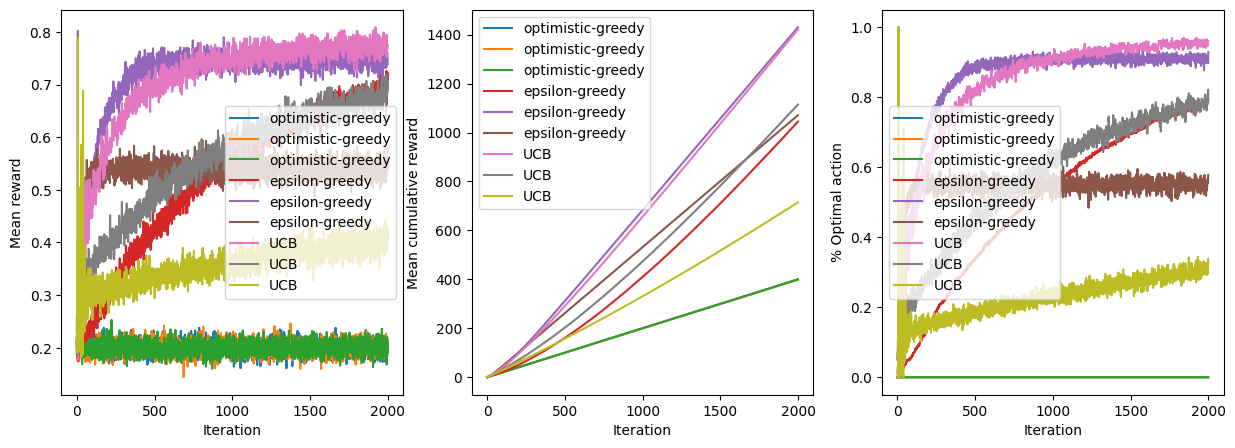

In [16]:
epsilon = [0.01, 0.1, 0.5]
c = [1, 2, 5]
optimistic_init = [10, 20, 50]

optimistic_agents = [Agent(learning_rule="averaging", decision_rule="optimistic-greedy", param={"optimistic_initial_value": optimistic_init}) for optimistic_init in optimistic_init]
epsilon_agents = [Agent(learning_rule="averaging", decision_rule="epsilon-greedy", param={"epsilon": epsilon}) for epsilon in epsilon]
ucb_agents = [Agent(learning_rule="averaging", decision_rule="UCB", param={"UCB_param": c}) for c in c]

agents = optimistic_agents + epsilon_agents + ucb_agents

[rewards, actions] = simulateBandits(agents, narms=nb_arms, initp=p_init, repetitions=T, N=N)

plot_results(agents, actions, rewards)

### Question 2
The asymptotic probability of taking the optimal action for $\epsilon$-greedy algorithm is $\frac{1 - \epsilon}{\epsilon / 10}$.

### Question 3
For a small $T$, the $\epsilon$ should be chosen small.
For a large $T$, the $\epsilon$ should be chosen large.

In the previous example for T = 2000, the optimal $\epsilon$ is around 0.1.

### Question 4
The spikes observed are due to lucky initial guesses. They tend to disappear as the number of iterations increases for UCB since the algorithm explores more and become more confident about the rewards of each action.